数据删除 数据填充KNN

In [108]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer


In [115]:
X = np.load('./data_set/X_train.npy')
Y = np.load('./data_set/y_train.npy')
print("处理前的X形状:", X.shape)

处理前的X形状: (1000, 111)


In [116]:
# 第一步：删除特征缺失超过60%的列
# 计算每列的缺失值比例
column_missing_ratio = np.mean(np.isnan(X), axis=0)
# 找到缺失值比例大于60%的列索引
columns_to_drop = np.where(column_missing_ratio > 0.6)[0]
# 删除这些列
X = np.delete(X, columns_to_drop, axis=1)
print("删除特征值缺失超过60%后的X形状:", X.shape)


# 第二步：删除缺失超过20%的行
# 计算每行的缺失值比例
row_missing_ratio = np.mean(np.isnan(X), axis=1)
# 找到缺失值比例大于20%的行索引
rows_to_drop = np.where(row_missing_ratio > 0.2)[0]
# 同时在X和Y中删除这些行
X = np.delete(X, rows_to_drop, axis=0)
Y = np.delete(Y, rows_to_drop, axis=0)
print("删除缺失值超过20%后的X形状:", X.shape)


# 第三步 删除一元特征值
# 检查每列的唯一值数量
unique_counts = np.array([len(np.unique(X[:, i])) for i in range(X.shape[1])])
# 找到唯一值数量为1的列索引
columns_to_drop_unary = np.where(unique_counts == 1)[0]
# 删除这些一元特征列
X = np.delete(X, columns_to_drop_unary, axis=1)
print("删除一元特征后的X形状:", X.shape)

删除特征值缺失超过60%后的X形状: (1000, 107)
删除缺失值超过20%后的X形状: (918, 107)
删除一元特征后的X形状: (918, 103)


In [117]:
# 保存删除后的数据
# 保存处理后的X到.npy文件
np.save('./data_set/X_train_drop.npy', X)

# 保存处理后的Y到.npy文件
np.save('./data_set/Y_train_drop.npy', Y)

KNN填充

In [111]:
# 加载数据
X_train_drop = np.load('./data_set/X_train_drop.npy')
Y_train_drop = np.load('./data_set/X_train_drop.npy')

# 创建KNNImputer实例
# 默认情况下，n_neighbors=5，即考虑5个最近邻
imputer = KNNImputer(n_neighbors=5)

# 使用fit_transform方法填充缺失值
X_filled = imputer.fit_transform(X)

# 保存处理后的X到.npy文件
np.save('./data_set/X_train_processed.npy', X_filled)

# 保存处理后的Y到.npy文件
np.save('./data_set/Y_train_processed.npy', Y)

评估相关性

c:\Users\29848\anaconda3\envs\COMP9417_ML\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


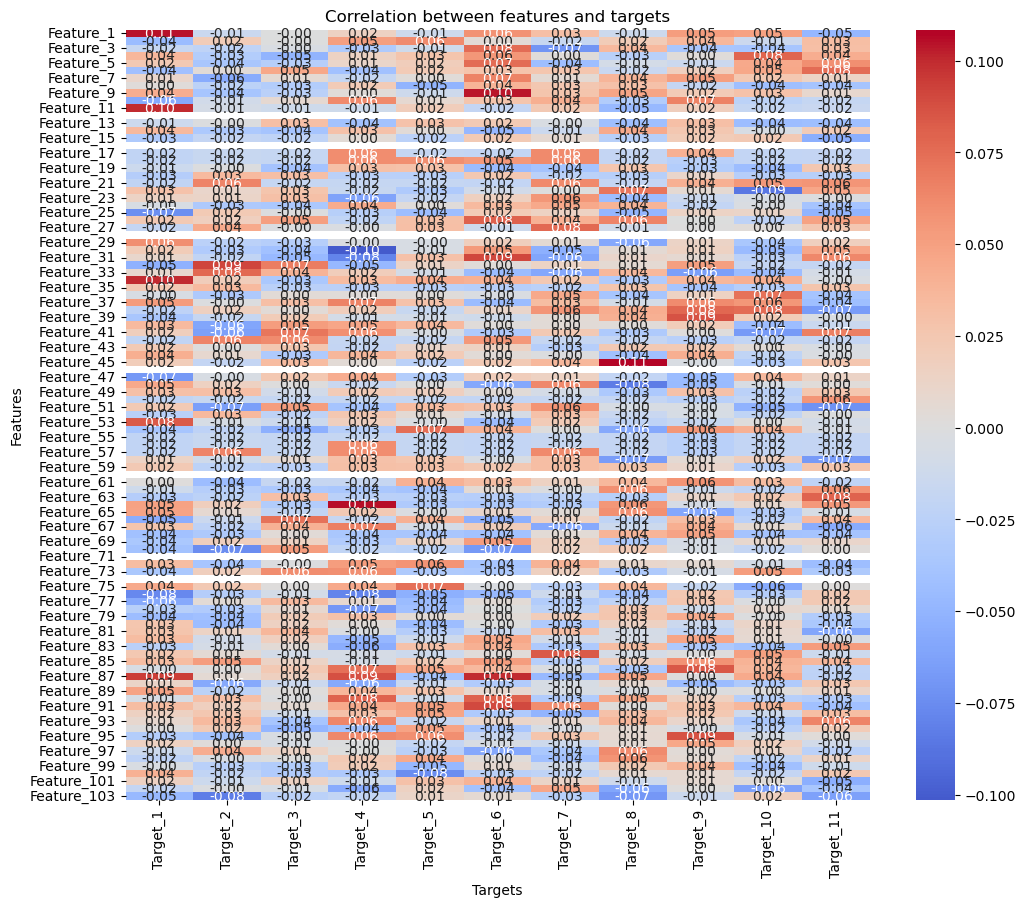

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

X = np.load('./data_set/X_train_processed.npy')
Y = np.load('./data_set/Y_train_processed.npy')
# 我们需要为列提供一些名称
feature_names = [f"Feature_{i}" for i in range(1, X.shape[1] + 1)]  # 为 X 创建列名
target_names = [f"Target_{j}" for j in range(1,  Y.shape[1] + 1)]     # 为 Y 创建列名

X_df = pd.DataFrame(X, columns=feature_names)
Y_df = pd.DataFrame(Y, columns=target_names)

# 计算每个特征与每个目标之间的相关系数
correlation_matrix = pd.DataFrame(data=np.zeros((X.shape[1], Y.shape[1])), columns=target_names, index=feature_names)
for target_col in Y_df.columns:
    for feature_col in X_df.columns:
        if not X_df[feature_col].isnull().any() and not Y_df[target_col].isnull().any():  # 确保没有缺失值
            corr, _ = pearsonr(X_df[feature_col], Y_df[target_col])
            correlation_matrix.at[feature_col, target_col] = corr

# 可视化热图，以显示特征和目标之间的相关性
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between features and targets")
plt.xlabel("Targets")
plt.ylabel("Features")
plt.show()


相关性填充

In [127]:
import numpy as np
import pandas as pd

# 加载数据
X_train_drop = np.load('./data_set/X_train_drop.npy')
Y_train_drop = np.load('./data_set/Y_train_drop.npy')

# 将Numpy数组转换为Pandas DataFrame以便于操作
X_train_df = pd.DataFrame(X_train_drop)
Y_train_df = pd.DataFrame(Y_train_drop)

# 计算X_train中每个特征与Y_train中每个目标变量的相关性
correlation_results = pd.DataFrame(index=X_train_df.columns)
for col in Y_train_df.columns:
    correlations = X_train_df.corrwith(Y_train_df[col])
    correlation_results[col] = correlations

# 找出每个特征与其相关性最强的目标变量
max_correlation_targets = correlation_results.apply(lambda x: x.abs().idxmax(), axis=1)

def fill_missing_values(df, target_df, max_correlation_targets):
    for feature in df.columns:
        if df[feature].isnull().any():  # 只处理含有缺失值的特征
            target = max_correlation_targets.get(feature)
            if pd.notna(target):  # 确保目标不是 NaN
                # 找到与目标变量最相关的特征
                target_correlations = df.corrwith(target_df.iloc[:, int(target)]).drop(feature)
                most_correlated_feature = target_correlations.abs().idxmax()
                # 根据特征类型选择填充方法
                if df[most_correlated_feature].dtype == 'float64':  # 连续特征
                    fill_value = df[most_correlated_feature].median() if df[most_correlated_feature].skew() > 1 else df[most_correlated_feature].mean()
                else:  # 离散特征
                    fill_value = df[most_correlated_feature].mode()[0]
            else:
                # 没有有效的目标，使用全局均值或众数作为后备
                if df[feature].dtype == 'float64':
                    fill_value = df[feature].median() if df[feature].skew() > 1 else df[feature].mean()
                else:
                    fill_value = df[feature].mode()[0]

            df[feature].fillna(fill_value, inplace=True)

# 使用修改后的填充方法
fill_missing_values(X_train_df, Y_train_df, max_correlation_targets)

# 检查是否还有缺失值
final_missing_values = X_train_df.isnull().sum().sum()
print("Remaining Missing Values:", final_missing_values)

# Convert the filled DataFrame back to a numpy array
X_train_filled = X_train_df.to_numpy()

# Save the filled array to a .npy file
np.save('./data_set/X_train_filled.npy', X_train_filled)

Remaining Missing Values: 0
